In [86]:
# import eland official API
# check it on https://github.com/elastic/eland
import eland as ed

# other imports
import pandas as pd
import matplotlib.pyplot as plt

# import elasticsearch-py client
from elasticsearch import Elasticsearch

# Function for pretty-printing JSON
def json(raw):
    import json
    print(json.dumps(raw, indent=2, sort_keys=True))

In [87]:
# Connect to an Elasticsearch instance
# here we use the official Elastic Python client
# check it on https://github.com/elastic/elasticsearch-py
es = Elasticsearch(
  ['http://localhost:9200'],
  http_auth=("es_kbn", "changeme")
)
# print the connection object info (same as visiting http://localhost:9200)
# make sure your elasticsearch node/cluster respond to requests
json(es.info())

{
  "cluster_name": "churn",
  "cluster_uuid": "K3nB4fp_QcyjpY-e2XVUbA",
  "name": "node-01",
  "tagline": "You Know, for Search",
  "version": {
    "build_date": "2020-07-22T19:31:37.655268Z",
    "build_flavor": "default",
    "build_hash": "bbbd2282a6668869c41efc5713ad8214d44c0ad1",
    "build_snapshot": true,
    "build_type": "zip",
    "lucene_version": "8.6.0",
    "minimum_index_compatibility_version": "7.0.0",
    "minimum_wire_compatibility_version": "7.10.0",
    "number": "8.0.0-SNAPSHOT"
  }
}


In [90]:
# Load the dataset from the local csv file of call logs
pd_df = pd.read_csv("./Desktop/telcos-ecs/eland_es_analytics/invoices.csv", sep=';', encoding = 'unicode_escape').dropna()
pd_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 541909 entries, 0 to 541908
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   invoice_id         541909 non-null  object 
 1   item_id            541909 non-null  int64  
 2   item_model         541909 non-null  object 
 3   item_name          541909 non-null  object 
 4   item_brand         541909 non-null  object 
 5   item_vendor        541909 non-null  object 
 6   order_qty          541909 non-null  int64  
 7   invoice_date       541909 non-null  object 
 8   unit_price         541909 non-null  float64
 9   customer_id        541909 non-null  int64  
 10  country_name       541909 non-null  object 
 11  country_latitude   541909 non-null  float64
 12  country_longitude  541909 non-null  float64
dtypes: float64(3), int64(3), object(7)
memory usage: 57.9+ MB


In [91]:
#converting the type of Invoice Date Field from string to datetime.
pd_df['invoice_date'] = pd.to_datetime(pd_df['invoice_date'])

# Arrange prices for phones
pd_df['unit_price'] = pd_df['unit_price'] * 10.00

# Rename the columns to be snake_case
pd_df.columns = [x.lower().replace(" ", "_") for x in pd_df.columns]

# Combine the 'latitude' and 'longitude' columns into one column 'location' for 'geo_point'
pd_df["country_location"] = pd_df[["country_latitude", "country_longitude"]].apply(lambda x: ",".join(str(item) for item in x), axis=1)

# Drop the old columns in favor of 'location'
pd_df.drop(["country_latitude", "country_longitude"], axis=1, inplace=True)

In [92]:
pd_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 541909 entries, 0 to 541908
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   invoice_id        541909 non-null  object        
 1   item_id           541909 non-null  int64         
 2   item_model        541909 non-null  object        
 3   item_name         541909 non-null  object        
 4   item_brand        541909 non-null  object        
 5   item_vendor       541909 non-null  object        
 6   order_qty         541909 non-null  int64         
 7   invoice_date      541909 non-null  datetime64[ns]
 8   unit_price        541909 non-null  float64       
 9   customer_id       541909 non-null  int64         
 10  country_name      541909 non-null  object        
 11  country_location  541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(7)
memory usage: 53.7+ MB


In [93]:
# Load the data into elasticsearch
ed_df = ed.pandas_to_eland(
    pd_df=pd_df,
    es_client=es,

    # Where the data will live in Elasticsearch
    es_dest_index="es-invoices",

    # Type overrides for certain columns, this can be used to customize index mapping before ingest
    es_type_overrides={
        "invoice_id": "keyword",
        "item_id": "keyword",
        "item_model": "keyword",
        "item_name": "keyword",     
        "item_brand": "keyword",
        "item_vendor": "keyword",   
        "order_qty": "integer",
        "invoice_date": "date",
        "unit_price": "float",  
        "customer_id": "keyword",
        "country_name": "keyword",
        "country_location": "geo_point"  
    },

    # If the index already exists what should we do?
    es_if_exists="replace",

    # Wait for data to be indexed before returning
    es_refresh=True,
)

In [72]:
ed_df.info()

<class 'eland.dataframe.DataFrame'>
Index: 28 entries, 0 to 27
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   country_location  28 non-null     object        
 1   country_name      28 non-null     object        
 2   customer_id       28 non-null     object        
 3   invoice_date      28 non-null     datetime64[ns]
 4   invoice_id        28 non-null     object        
 5   item_brand        28 non-null     object        
 6   item_id           28 non-null     object        
 7   item_model        28 non-null     object        
 8   item_name         28 non-null     object        
 9   item_vendor       28 non-null     object        
 10  order_qty         28 non-null     int64         
 11  unit_price        28 non-null     float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(9)
memory usage: 64.0 bytes


In [94]:
json(es.indices.get_mapping(index="es-invoices"))

{
  "es-invoices": {
    "mappings": {
      "properties": {
        "country_location": {
          "type": "geo_point"
        },
        "country_name": {
          "type": "keyword"
        },
        "customer_id": {
          "type": "keyword"
        },
        "invoice_date": {
          "type": "date"
        },
        "invoice_id": {
          "type": "keyword"
        },
        "item_brand": {
          "type": "keyword"
        },
        "item_id": {
          "type": "keyword"
        },
        "item_model": {
          "type": "keyword"
        },
        "item_name": {
          "type": "keyword"
        },
        "item_vendor": {
          "type": "keyword"
        },
        "order_qty": {
          "type": "integer"
        },
        "unit_price": {
          "type": "float"
        }
      }
    }
  }
}


In [85]:
ed_df = ed.read_csv("./Desktop/telcos-ecs/eland_es_analytics/invoices_dataset.csv",
                es_client=es,

    # Where the data will live in Elasticsearch
    es_dest_index="es-invoices",

    # Type overrides for certain columns, this can be used to customize index mapping before ingest
    es_type_overrides={
        "invoice_id": "keyword",
        "item_id": "keyword",
        "item_model": "keyword",
        "item_name": "keyword",     
        "item_brand": "keyword",
        "item_vendor": "keyword",   
        "order_qty": "integer",
        "invoice_date": "keyword",
        "unit_price": "float",  
        "customer_id": "keyword",
        "country_name": "keyword",
        "country_location": "geo_point"  
    },

    # If the index already exists what should we do?
    es_if_exists="replace",

    # Wait for data to be indexed before returning
    es_refresh=True,
)
ed_df.info()

<class 'eland.dataframe.DataFrame'>
Index: 28 entries, 0 to 27
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   country_latitude   28 non-null     float64
 1   country_longitude  28 non-null     float64
 2   country_name       28 non-null     object 
 3   customer_id        28 non-null     object 
 4   invoice_date       28 non-null     object 
 5   invoice_id         28 non-null     object 
 6   item_brand         28 non-null     object 
 7   item_id            28 non-null     object 
 8   item_model         28 non-null     object 
 9   item_name          28 non-null     object 
 10  item_vendor        28 non-null     object 
 11  order_qty          28 non-null     int64  
 12  unit_price         28 non-null     float64
dtypes: float64(3), int64(1), object(9)
memory usage: 64.0 bytes


In [95]:
ed_df.index.es_index_field

'_id'

In [96]:
ed_df.columns

Index(['country_location', 'country_name', 'customer_id', 'invoice_date',
       'invoice_id', 'item_brand', 'item_id', 'item_model', 'item_name',
       'item_vendor', 'order_qty', 'unit_price'],
      dtype='object')

In [97]:
# Aggregating values
ed_df.describe()

,order_qty,unit_price
count,541909.000000,541909.000000
mean,9.552250,46.111193
std,218.080957,967.597634
min,-80995.000000,-110620.601562
25%,1.000000,12.500000
50%,3.000000,20.799999
75%,10.000000,41.299999
max,80995.000000,389700.000000


In [98]:
# Shape is determined by using count API
ed_df.shape

(541909, 12)

In [99]:
ed_invoices = ed.read_es(es, 'es-invoices')

In [100]:
ed_invoices.head()

,country_location,country_name,customer_id,invoice_date,invoice_id,item_brand,item_id,item_model,item_name,item_vendor,order_qty,unit_price
138000,"31.791702,-7.09262",Morocco,16218,2019-05-17 11:07:00,553464,Samsung,35310308,SM-J110H/DS,Samsung SM-J110H/DS,Samsung Korea,12,16.5
138001,"31.791702,-7.09262",Morocco,16218,2019-05-17 11:07:00,553464,Samsung,35271109,SM-G960F/DS,GALAXY S9 SM-G960F/DS,Samsung Korea,12,14.5
138002,"31.791702,-7.09262",Morocco,16218,2019-05-17 11:07:00,553464,Samsung,35283806,GT-I8262,GALAXY CORE GT-I8262,Samsung Korea,4,32.9
138003,"31.791702,-7.09262",Morocco,16218,2019-05-17 11:07:00,553464,Redmi,86964104,M1908C3JG,Redmi Note 8,Xiaomi Communications Co Ltd,12,81.5
138004,"31.791702,-7.09262",Morocco,16218,2019-05-17 11:07:00,553464,Redmi,86094104,M1901F7G,Redmi Note7,Xiaomi Communications Co Ltd,48,8.5


In [41]:
ed_invoices.info()

<class 'eland.dataframe.DataFrame'>
Index: 541909 entries, 1500 to 541908
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   country_location  541909 non-null  object        
 1   country_name      541909 non-null  object        
 2   customer_id       541909 non-null  object        
 3   invoice_date      541909 non-null  datetime64[ns]
 4   invoice_id        541909 non-null  object        
 5   item_brand        541909 non-null  object        
 6   item_id           541909 non-null  object        
 7   item_model        541909 non-null  object        
 8   item_name         541909 non-null  object        
 9   item_vendor       541909 non-null  object        
 10  order_qty         541909 non-null  int64         
 11  unit_price        541909 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(9)
memory usage: 64.0 bytes


In [102]:
# DataFrame has many APIs compatible with Pandas
ed_invoices.head(10)

,country_location,country_name,customer_id,invoice_date,invoice_id,item_brand,item_id,item_model,item_name,item_vendor,order_qty,unit_price
138000,"31.791702,-7.09262",Morocco,16218,2019-05-17 11:07:00,553464,Samsung,35310308,SM-J110H/DS,Samsung SM-J110H/DS,Samsung Korea,12,16.5
138001,"31.791702,-7.09262",Morocco,16218,2019-05-17 11:07:00,553464,Samsung,35271109,SM-G960F/DS,GALAXY S9 SM-G960F/DS,Samsung Korea,12,14.5
138002,"31.791702,-7.09262",Morocco,16218,2019-05-17 11:07:00,553464,Samsung,35283806,GT-I8262,GALAXY CORE GT-I8262,Samsung Korea,4,32.9
138003,"31.791702,-7.09262",Morocco,16218,2019-05-17 11:07:00,553464,Redmi,86964104,M1908C3JG,Redmi Note 8,Xiaomi Communications Co Ltd,12,81.5
138004,"31.791702,-7.09262",Morocco,16218,2019-05-17 11:07:00,553464,Redmi,86094104,M1901F7G,Redmi Note7,Xiaomi Communications Co Ltd,48,8.5
138005,"31.791702,-7.09262",Morocco,16218,2019-05-17 11:07:00,553464,Samsung,35463609,SM-J701F/DS,Galaxy J7,Samsung Korea,36,12.5
138006,"31.791702,-7.09262",Morocco,16218,2019-05-17 11:07:00,553464,Samsung,35264811,SM-T515,Galaxy Tab A 2019,Samsung Korea,12,14.5
138007,"31.791702,-7.09262",Morocco,16218,2019-05-17 11:09:00,553465,Redmi,86169704,M1906G7G,Redmi Note 8 Pro,Xiaomi Communications Co Ltd,80,14.5
138008,"31.791702,-7.09262",Morocco,16218,2019-06-07 15:28:00,C555877,Redmi,86964104,M1908C3JG,Redmi Note 8,Xiaomi Communications Co Ltd,-1,81.5
138009,"31.791702,-7.09262",Morocco,16218,2019-06-07 15:28:00,C555877,Samsung,35271109,SM-G960F/DS,GALAXY S9 SM-G960F/DS,Samsung Korea,-2,14.5


In [103]:
# DataFrame has many APIs compatible with Pandas
ed_invoices.columns

Index(['country_location', 'country_name', 'customer_id', 'invoice_date',
       'invoice_id', 'item_brand', 'item_id', 'item_model', 'item_name',
       'item_vendor', 'order_qty', 'unit_price'],
      dtype='object')

In [104]:
# DataFrame has many APIs compatible with Pandas
ed_invoices.customer_id

138000    16218
138001    16218
138002    16218
138003    16218
138004    16218
          ...  
541904    16265
541905    16262
541906    16262
541907    16262
541908    16261
Name: customer_id, Length: 541909, dtype: int64

In [106]:
# DataFrame has many APIs compatible with Pandas
ed_invoices["invoice_id"]

138000    553464
138001    553464
138002    553464
138003    553464
138004    553464
           ...  
541904    581498
541905    581498
541906    581498
541907    581498
541908    581498
Name: invoice_id, Length: 541909, dtype: object

In [110]:
# DataFrame has many APIs compatible with Pandas
ed_invoices[ed_invoices.item_brand.isin(["Redmi", "Samsung"])]

,country_location,country_name,customer_id,invoice_date,invoice_id,item_brand,item_id,item_model,item_name,item_vendor,order_qty,unit_price
138000,"31.791702,-7.09262",Morocco,16218,2019-05-17 11:07:00,553464,Samsung,35310308,SM-J110H/DS,Samsung SM-J110H/DS,Samsung Korea,12,16.5
138001,"31.791702,-7.09262",Morocco,16218,2019-05-17 11:07:00,553464,Samsung,35271109,SM-G960F/DS,GALAXY S9 SM-G960F/DS,Samsung Korea,12,14.5
138002,"31.791702,-7.09262",Morocco,16218,2019-05-17 11:07:00,553464,Samsung,35283806,GT-I8262,GALAXY CORE GT-I8262,Samsung Korea,4,32.9
138003,"31.791702,-7.09262",Morocco,16218,2019-05-17 11:07:00,553464,Redmi,86964104,M1908C3JG,Redmi Note 8,Xiaomi Communications Co Ltd,12,81.5
138004,"31.791702,-7.09262",Morocco,16218,2019-05-17 11:07:00,553464,Redmi,86094104,M1901F7G,Redmi Note7,Xiaomi Communications Co Ltd,48,8.5
...,...,...,...,...,...,...,...,...,...,...,...,...
541904,"31.791702,-7.09262",Morocco,16265,2019-12-09 10:26:00,581498,Redmi,86041704,M1908C3IG,Redmi 8,Xiaomi Communications Co Ltd,5,41.3
541905,"31.791702,-7.09262",Morocco,16262,2019-12-09 10:26:00,581498,Redmi,86403204,M1908C3JG,Redmi Note 8,Xiaomi Communications Co Ltd,4,41.3
541906,"31.791702,-7.09262",Morocco,16262,2019-12-09 10:26:00,581498,Samsung,35159910,SM-J410F/DS,GALAXY J4 CORE SM-J410F/DS,Samsung Korea,1,49.6
541907,"31.791702,-7.09262",Morocco,16262,2019-12-09 10:26:00,581498,Samsung,35438811,SM-A315F/DS,Galaxy A31,Samsung Korea,1,107.9


In [112]:
# DataFrame has many APIs compatible with Pandas
print(ed_invoices[ed_invoices.item_brand.isin(["Redmi", "Samsung"])].es_info())
#print(df.tail(10).es_info())

es_index_pattern: es-invoices
Index:
 es_index_field: _id
 is_source_field: False
Mappings:
 capabilities:
                     es_field_name  is_source   es_dtype es_date_format        pd_dtype  is_searchable  is_aggregatable  is_scripted aggregatable_es_field_name
country_location  country_location       True  geo_point           None          object           True             True        False           country_location
country_name          country_name       True    keyword           None          object           True             True        False               country_name
customer_id            customer_id       True    keyword           None          object           True             True        False                customer_id
invoice_date          invoice_date       True       date           None  datetime64[ns]           True             True        False               invoice_date
invoice_id              invoice_id       True    keyword           None          object      

In [113]:
# DataFrame has many APIs compatible with Pandas
print(ed_invoices.tail(10).es_info())

es_index_pattern: es-invoices
Index:
 es_index_field: _id
 is_source_field: False
Mappings:
 capabilities:
                     es_field_name  is_source   es_dtype es_date_format        pd_dtype  is_searchable  is_aggregatable  is_scripted aggregatable_es_field_name
country_location  country_location       True  geo_point           None          object           True             True        False           country_location
country_name          country_name       True    keyword           None          object           True             True        False               country_name
customer_id            customer_id       True    keyword           None          object           True             True        False                customer_id
invoice_date          invoice_date       True       date           None  datetime64[ns]           True             True        False               invoice_date
invoice_id              invoice_id       True    keyword           None          object      

In [116]:
# Aggregating values
ed_invoices.describe()

,order_qty,unit_price
count,541909.000000,541909.000000
mean,9.552250,46.111193
std,218.080957,967.597634
min,-80995.000000,-110620.601562
25%,1.000000,12.500000
50%,3.000000,20.799999
75%,10.000000,41.299999
max,80995.000000,389700.000000


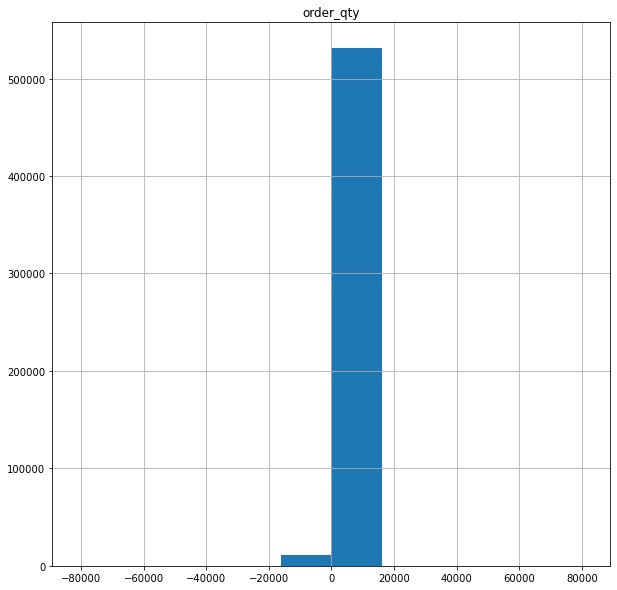

In [119]:
# Plotting with matplotlib
from matplotlib import pyplot as plt
ed_invoices[["order_qty"]].hist(figsize=[10,10])
plt.show()

In [120]:
# es_query() allows for the full Elasticsearch querying capabilities
ed_invoices.es_query({
  "range": {
    "unit_price": {
      "gte": 1000,
      "lte": 2000
    }
  }
})

,country_location,country_name,customer_id,invoice_date,invoice_id,item_brand,item_id,item_model,item_name,item_vendor,order_qty,unit_price
138080,"31.791702,-7.09262",Morocco,16216,2019-03-17 15:34:00,546862,TP-LINK,86872502,M7300,TP-LINK M7300,TP-Link Technologies Co Ltd,1,1650.0
137099,"31.791702,-7.09262",Morocco,16240,2019-09-23 13:44:00,568065,Samsung,35862706,SM-G355H/DS,Samsung SM-G355H/DS,Samsung Korea,2,1450.0
142048,"31.791702,-7.09262",Morocco,16143,2018-12-20 12:51:00,539581,Samsung,35898907,SM-A310F/DS,Samsung SM-A310F/DS,Samsung Korea,2,1250.0
142456,"31.791702,-7.09262",Morocco,16133,2019-05-03 10:42:00,551559,SEASHARK,35237711,X10,"SEASHARK, X10",Kamil Trade Links,2,1100.0
148580,"31.791702,-7.09262",Morocco,16029,2019-09-13 17:28:00,C566614,Samsung,35631908,SM-A320F/DS,GALAXY A3 SM-A320F/DS,Samsung Korea,-1,1022.4
...,...,...,...,...,...,...,...,...,...,...,...,...
507511,"31.791702,-7.09262",Morocco,16806,2019-10-10 16:02:00,570465,Redmi,86723304,M1908C3IG,Redmi 8,Xiaomi Communications Co Ltd,1,1884.6
507920,"31.791702,-7.09262",Morocco,16800,2019-10-11 16:29:00,570688,Redmi,86723304,M1908C3IG,Redmi 8,Xiaomi Communications Co Ltd,1,1990.4
508169,"31.791702,-7.09262",Morocco,16794,2019-10-11 16:37:00,570690,Redmi,86723304,M1908C3IG,Redmi 8,Xiaomi Communications Co Ltd,1,1998.1
509637,"31.791702,-7.09262",Morocco,16777,2019-10-17 15:14:00,C571501,RIVO,35272707,RHYTHM RX150,RIVO RHYTHM RX150,Rivo Mobile,-1,1531.3


In [136]:
# Match query example
ed_invoices.es_query({"match": {"item_brand": "SEASHARK"}})

,country_location,country_name,customer_id,invoice_date,invoice_id,item_brand,item_id,item_model,item_name,item_vendor,order_qty,unit_price
142456,"31.791702,-7.09262",Morocco,16133,2019-05-03 10:42:00,551559,SEASHARK,35237711,X10,"SEASHARK, X10",Kamil Trade Links,2,1100.0
144630,"31.791702,-7.09262",Morocco,16096,2019-03-20 13:38:00,547064,SEASHARK,35237711,X10,"SEASHARK, X10",Kamil Trade Links,1,1250.0
153363,"31.791702,-7.09262",Morocco,15976,2019-05-03 17:12:00,551724,SEASHARK,35238011,P30,"SEASHARK, P30",Kamil Trade Links,2,8.3
157513,"31.791702,-7.09262",Morocco,15867,2018-12-05 14:17:00,537200,SEASHARK,35238011,P30,"SEASHARK, P30",Kamil Trade Links,3,14.9
181136,"31.791702,-7.09262",Morocco,15524,2019-11-15 12:09:00,576512,SEASHARK,35237711,X10,"SEASHARK, X10",Kamil Trade Links,4,1100.0
...,...,...,...,...,...,...,...,...,...,...,...,...
446665,"31.791702,-7.09262",Morocco,17730,2019-03-17 18:15:00,546888,SEASHARK,35237911,S10+,"SEASHARK, S10+",Kamil Trade Links,6,8.3
446827,"31.791702,-7.09262",Morocco,17730,2019-03-17 18:18:00,546891,SEASHARK,35237911,S10+,"SEASHARK, S10+",Kamil Trade Links,6,8.3
447880,"31.791702,-7.09262",Morocco,17716,2019-03-20 11:00:00,547042,SEASHARK,35237911,S10+,"SEASHARK, S10+",Kamil Trade Links,2,8.3
448089,"31.791702,-7.09262",Morocco,17711,2019-03-22 09:23:00,547248,SEASHARK,35237911,S10+,"SEASHARK, S10+",Kamil Trade Links,2,8.3


In [140]:
# Pull a subset of your data for building graphs / operations locally.
sample_df = ed_invoices[ed_invoices.item_brand == "SEASHARK"].sample(50).to_pandas()
sample_df.info()
print(type(sample_df))

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, 106944 to 95914
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   country_location  50 non-null     object        
 1   country_name      50 non-null     object        
 2   customer_id       50 non-null     int64         
 3   invoice_date      50 non-null     datetime64[ns]
 4   invoice_id        50 non-null     object        
 5   item_brand        50 non-null     object        
 6   item_id           50 non-null     int64         
 7   item_model        50 non-null     object        
 8   item_name         50 non-null     object        
 9   item_vendor       50 non-null     object        
 10  order_qty         50 non-null     int64         
 11  unit_price        50 non-null     float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(7)
memory usage: 5.1+ KB
<class 'pandas.core.frame.DataFrame'>


In [142]:
# Now, let’s see the data types of our fields. Running df.dtypes,
# we can see that elasticsearch field types are mapped to pandas field types.
ed_invoices.dtypes

country_location            object
country_name                object
customer_id                 object
invoice_date        datetime64[ns]
invoice_id                  object
item_brand                  object
item_id                     object
item_model                  object
item_name                   object
item_vendor                 object
order_qty                    int64
unit_price                 float64
dtype: object

In [143]:
# We also offer a .es_info() data frame method that shows all info about the underlying index.
# It also contains information about operations being passed from data frame methods to elasticsearch.
# More on this later.
print(ed_invoices.es_info())

es_index_pattern: es-invoices
Index:
 es_index_field: _id
 is_source_field: False
Mappings:
 capabilities:
                     es_field_name  is_source   es_dtype es_date_format        pd_dtype  is_searchable  is_aggregatable  is_scripted aggregatable_es_field_name
country_location  country_location       True  geo_point           None          object           True             True        False           country_location
country_name          country_name       True    keyword           None          object           True             True        False               country_name
customer_id            customer_id       True    keyword           None          object           True             True        False                customer_id
invoice_date          invoice_date       True       date           None  datetime64[ns]           True             True        False               invoice_date
invoice_id              invoice_id       True    keyword           None          object      

In [144]:
# the construction of a boolean vector maps directly to an elasticsearch query
print(ed_invoices['country_name'] == 'Morocco')
ed_invoices[(ed_invoices['country_name'] == 'Morocco')].head(5)

{'term': {'country_name': 'Morocco'}}


,country_location,country_name,customer_id,invoice_date,invoice_id,item_brand,item_id,item_model,item_name,item_vendor,order_qty,unit_price
138000,"31.791702,-7.09262",Morocco,16218,2019-05-17 11:07:00,553464,Samsung,35310308,SM-J110H/DS,Samsung SM-J110H/DS,Samsung Korea,12,16.5
138001,"31.791702,-7.09262",Morocco,16218,2019-05-17 11:07:00,553464,Samsung,35271109,SM-G960F/DS,GALAXY S9 SM-G960F/DS,Samsung Korea,12,14.5
138002,"31.791702,-7.09262",Morocco,16218,2019-05-17 11:07:00,553464,Samsung,35283806,GT-I8262,GALAXY CORE GT-I8262,Samsung Korea,4,32.9
138003,"31.791702,-7.09262",Morocco,16218,2019-05-17 11:07:00,553464,Redmi,86964104,M1908C3JG,Redmi Note 8,Xiaomi Communications Co Ltd,12,81.5
138004,"31.791702,-7.09262",Morocco,16218,2019-05-17 11:07:00,553464,Redmi,86094104,M1901F7G,Redmi Note7,Xiaomi Communications Co Ltd,48,8.5
